In [1]:
!wget https://bit.ly/fruits_300_data -O fruits_300.npy
import numpy as np
fruits = np.load('fruits_300.npy')
fruits_2d = fruits.reshape(-1, 100*100) 


--2023-04-21 07:39:32--  https://bit.ly/fruits_300_data
Resolving bit.ly (bit.ly)... 67.199.248.11, 67.199.248.10
Connecting to bit.ly (bit.ly)|67.199.248.11|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/rickiepark/hg-mldl/raw/master/fruits_300.npy [following]
--2023-04-21 07:39:32--  https://github.com/rickiepark/hg-mldl/raw/master/fruits_300.npy
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rickiepark/hg-mldl/master/fruits_300.npy [following]
--2023-04-21 07:39:33--  https://raw.githubusercontent.com/rickiepark/hg-mldl/master/fruits_300.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... conne

In [2]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
pca.fit(fruits_2d)

PCA(n_components=50)

In [3]:
print(pca.components_.shape)

(50, 10000)


In [5]:
import matplotlib.pyplot as plt

def draw_fruits(arr, ratio=1):
  n = len(arr) # n은 샘플 개수

  #한 줄에 10개씩 이미지를 그림 샘플 개수를 10으로 나누어 전체 행 개수를 계산
  
  rows = int(np.ceil(n/10))
  
  #행이 1개면 열의 개수는 샘플 개수 그렇지 않으면 10개
  cols = n if rows < 2 else 10
  fig, axs = plt.subplots(rows, cols,
                          figsize=(cols*ratio, rows*ratio), squeeze=False)
  for i in range(rows):
    for j in range(cols):
      if i*10 + j < n:
        axs[i, j].imshow(arr[i*10 + j], cmap='gray_r')
      axs[i,j].axis('off')
  plt.show()

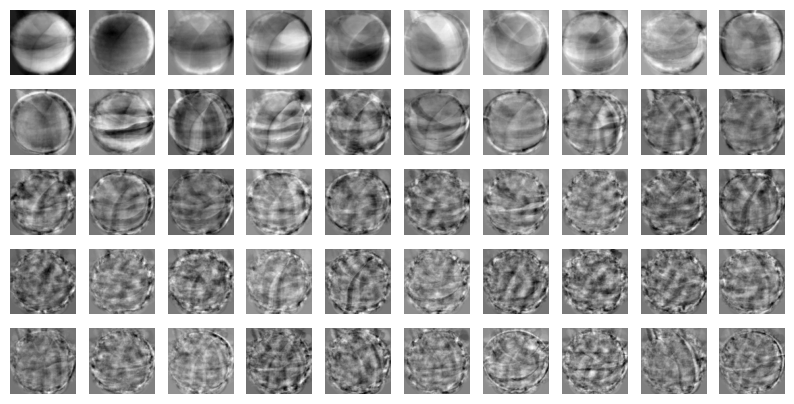

In [6]:
draw_fruits(pca.components_.reshape(-1, 100, 100))

이 주성분은 원본 데이터에서 가장 분산이 큰 방향을 순서대로 나타낸 것  
데이터 셋에 있는 어떤 특징을 잡아낸 것으로 생각 할 수도 있음  
주성분을 찾았으므로 원본 데이터를 주성분에 투영하여 특성의 개수를 10,000개에서 50개로  
줄일 수 있음  
PCA의 transform()메서드를 사용하여 원본 데이터의 차원을 50으로 줄임

In [7]:
print(fruits_2d.shape)

(300, 10000)


In [8]:
fruits_pca = pca.transform(fruits_2d)
print(fruits_pca.shape)

(300, 50)


# 원본 데이터 재구성
10,000개의 특성을 50개로 줄였음  
어느 정도 손실이 발생할 수밖에 없습니다.  
하지만 최대한 분산이 큰 방향으로 데이터를 투영했기 때문에 우너본 데이터를 상당 부분 재구성할 수 있음  
PCA 클래스는 이를 위해 inverse_transform() 메서드를 제공함  
앞서 50개의 차원으로 축소한 fruits_pca 데이터를 전달해 10,000개의 특성을 복원

In [9]:
fruits_inverse = pca.inverse_transform(fruits_pca)
print(fruits_inverse.shape)

(300, 10000)


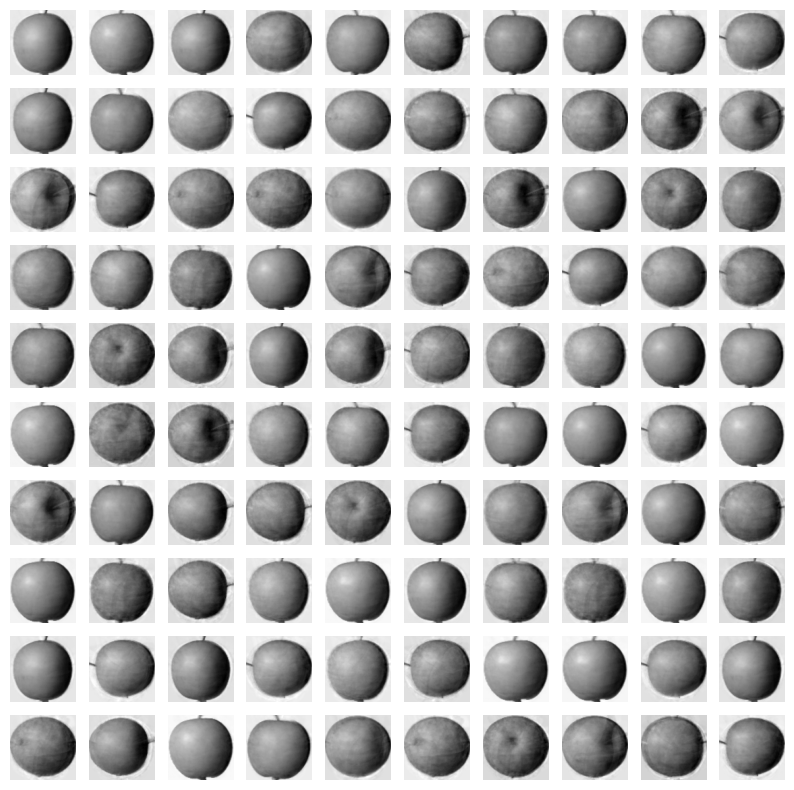

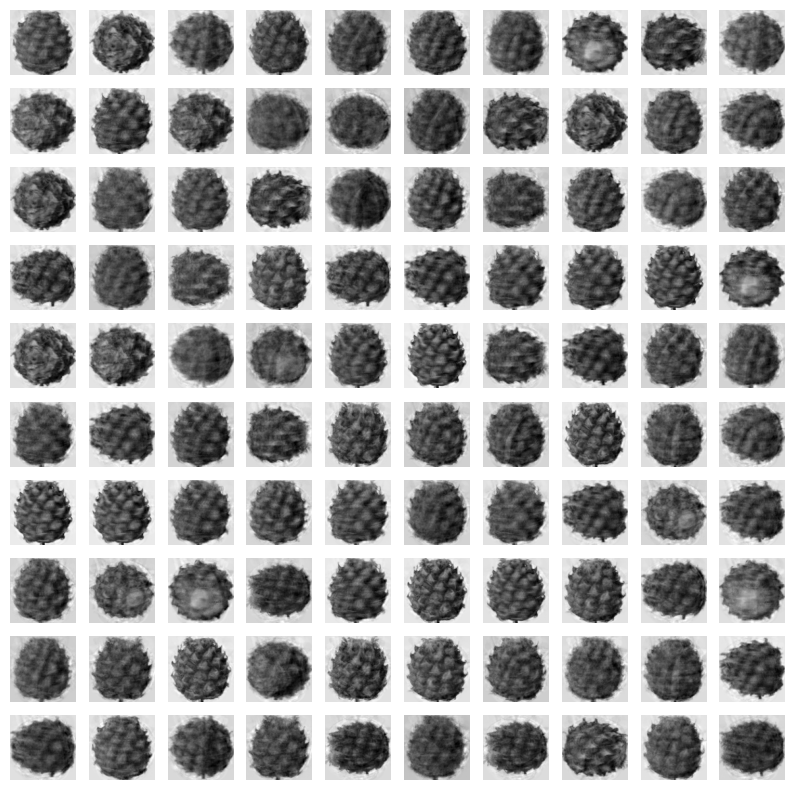

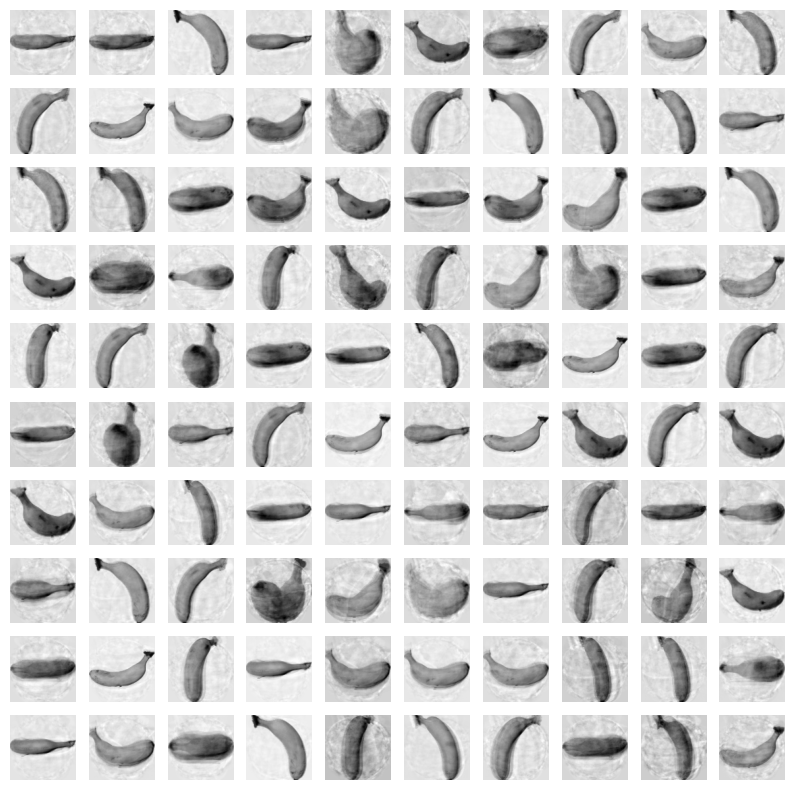

In [10]:
fruits_reconstruct = fruits_inverse.reshape(-1, 100, 100)
for start in [0, 100, 200]:
  draw_fruits(fruits_reconstruct[start:start+100])
  print("\n")

In [12]:
#분산을 얼마나 유지하고 있는지 확인하기 위함
print(np.sum(pca.explained_variance_ratio_))

0.9215672402992071


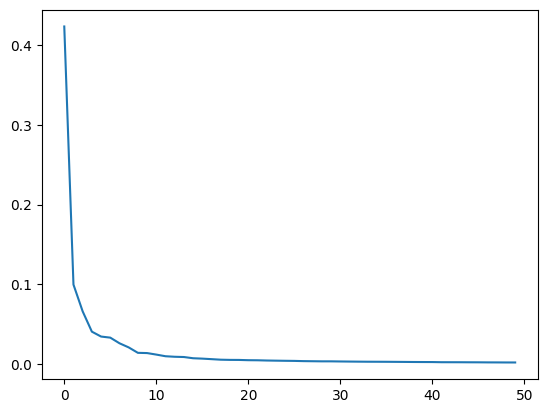

In [13]:
#분산을 plot()함수로 그래프를 출력
plt.plot(pca.explained_variance_ratio_)
plt.show()

In [14]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

In [15]:
# 지도 학습모델을 사용하려면 타깃값이 있어야함 사과를 0 / 파인애플을 1 / 바나나를 2 로 지정
target = np.array([0]*100 + [1]*100 + [2]*100)

In [16]:
from sklearn.model_selection import cross_validate
scores = cross_validate(lr, fruits_2d, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time']))

0.9966666666666667
1.708604335784912


In [17]:
scores = cross_validate(lr, fruits_pca, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time']))

1.0
0.042962503433227536


In [18]:
# 50개의 특성만 사용햇는데도 정확도가 100%이고 푼련시간은 0.03초로 20배이상 감소하였음
# PCA로 훈련 데이터의 차원을 축소하면 저장 공간 뿐만 아니라 머신러닝 모델의 훈련 속도도 높일 수 있음
# PCA 클래스를 사용할 때 n_components 매개변수에 주성분의 개수를 지정했습니다. 
# PCA 클래스는 지정된 비율에 도달할 때까지 자동으로 주성분을 찾습니다. 
# 50%에 달하는 주성분을 찾도록 PCA 모델을 만들기
pca = PCA(n_components=0.5)
pca.fit(fruits_2d)

PCA(n_components=0.5)

In [19]:
print(pca.n_components_)

2


In [20]:
# 이 모델로 원본 데이터를 변환하기
# 주성분이 2개이므로 변환된 데이터의 크기는 (300, 2)가 될 것으로 예상
fruits_pca = pca.transform(fruits_2d)
print(fruits_pca.shape)

(300, 2)


In [22]:
scores = cross_validate(lr, fruits_pca, target)
print(np.mean(scores['test_score']))
print(np.mean(scores['fit_time']))

0.9933333333333334
0.030825233459472655


/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

In [23]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=3, random_state=42)
km.fit(fruits_pca)
print(np.unique(km.labels_, return_counts=True))

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


(array([0, 1, 2], dtype=int32), array([110,  99,  91]))


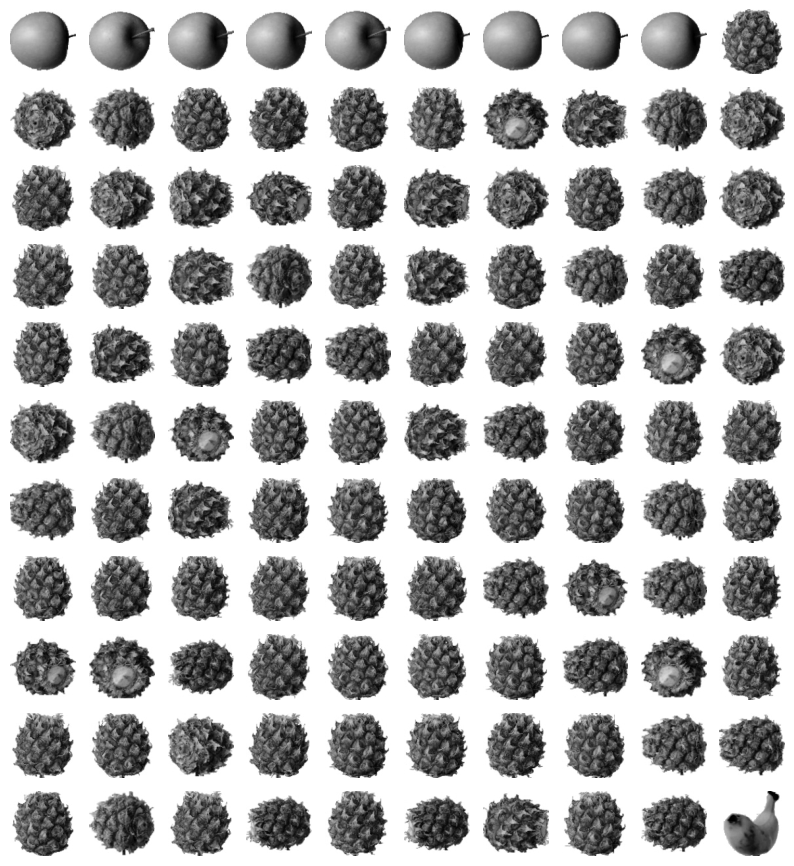

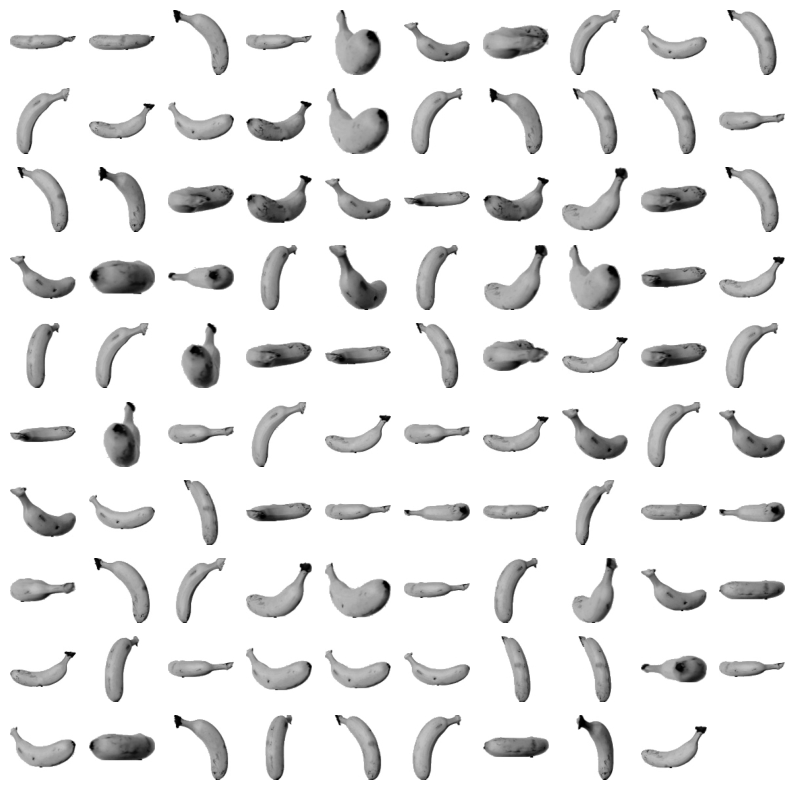

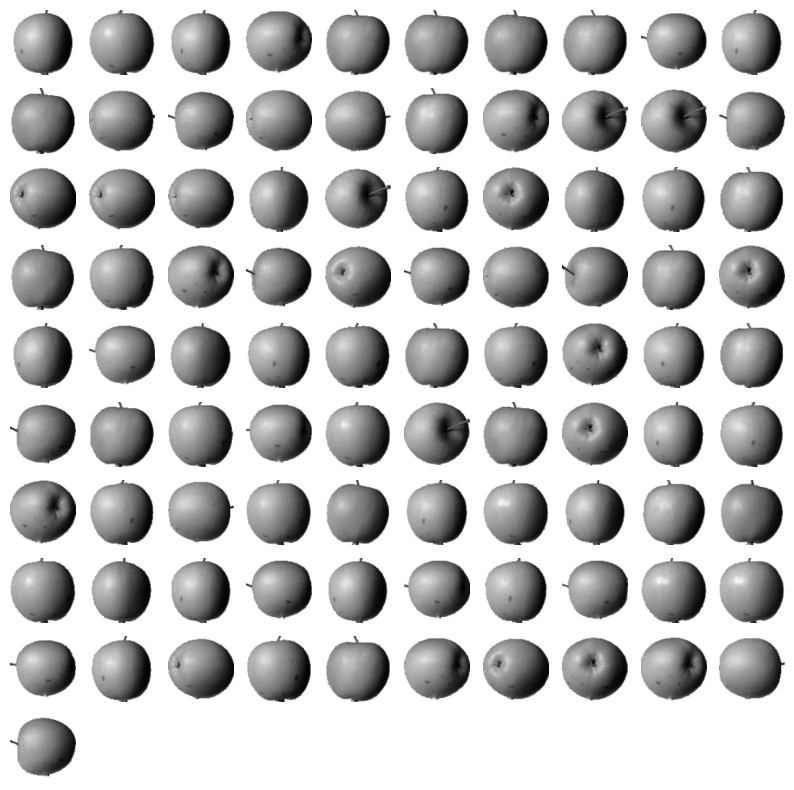

In [24]:
for label in range(0, 3):
  draw_fruits(fruits[km.labels_== label])
  print("\n")

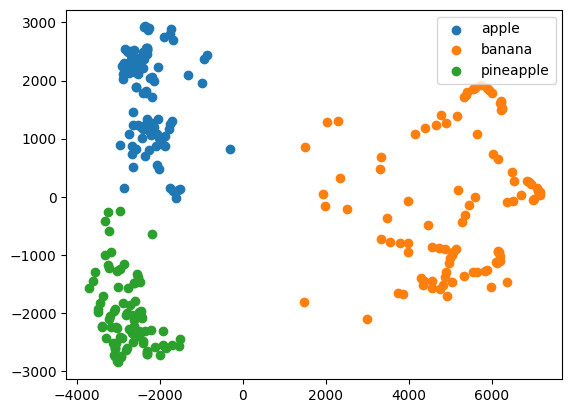

In [25]:
for label in range(0, 3):
  data = fruits_pca[km.labels_== label]
  plt.scatter(data[:,0], data[:,1])
plt.legend(['apple', 'banana', 'pineapple'])
plt.show()